In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC

!pip install pomegranate
from pomegranate import *

## Data Loading 

This step loads the images contained in the training dataset.

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
train_labels = [] #label of each image in x_train 
PATH = 'archive/Training'

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        train_img.append(img)
        train_labels.append(label)
        
new_size = (255, 255)

for i in range(len(train_img)):
    img = train_img[i] 
    train_img[i] = cv2.resize(img, new_size)
    train_img[i] = cv2.cvtColor(train_img[i], cv2.COLOR_RGB2GRAY)/255

train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)


# Dimensionality reduction by PCA implementation

See lab3 for more details

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_img.reshape((train_img.shape[0], 255*255)), train_labels, test_size = 0.3, random_state = 42)

In [4]:
from sklearn.preprocessing import StandardScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA


S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.transform(X_test)

## Classifier evaluation with different metrics

Many metrics are already computed by sklearn modules and methods. Here we propose to code some metrics from scratch, notably the binary confusion matrices, the F1-score, as well as K-fold cross-validation.

In [5]:
# Evaluation Buffers
classifiers = ["Multinomial", "Gaussian", "Complement", "Bernoulli", "Complex"]
PCA_comp = []
Acc = []
Pr = []
Rec = []
Spec= []
F1 = [] 
AUC = []

In [6]:
# Data to be exploited

n_comp = np.arange(2, 402, 20)
pca = PCA(n_components = 402)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

### Binary classification

From a confusion matrix, extract a binary one where i is the True Positive class represented by 1. The rest will be represented as 0.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report #to provide confusion matrix with rows = True values and columns = Predicted values

def conf_bin(conf, i):
    row_i = np.sum(conf[i,:]) - conf[i,i]
    col_i = np.sum(conf[:,i]) - conf[i,i]
    rest = np.sum(conf)- row_i - col_i - conf[i,i]
    new_conf = np.array([[conf[i,i], row_i],
                        [col_i, rest]])
    return new_conf

#how often a negative sample is correctly classified
def specificity(conf_i, weight):
    tp = conf_i[0,0]
    fn = conf_i[0,1]
    tn = conf_i[1,1]
    fp = conf_i[1,0]
    spec = weight*(tn/(tn + fp))
    return spec

### Plotting the confusion heatmap

In [8]:
def confusion_plot(conf_pred):
    columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

    plt.figure()
    plt.xticks(range(len(columns)),columns,rotation=90)
    plt.yticks(range(len(columns)),columns)
    im = plt.imshow(conf_pred, cmap='viridis',interpolation="nearest")
    plt.colorbar(im)

    plt.show(im)

### ROC analysis

The ROC curves and their areas give an estimation of the trade-off between TPR and FPR. In the multiclass case, it is necessary to plot the curves of each class against the others (One vs Rest strategy), and it is possible to do the average of all the curves ultimately (even though visualizing the curves separately enables to tell specifically which class has a problem).

In [9]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'no_tumor', 
                                        1: 'glioma', 
                                        2: 'pituitary',
                                        3: 'meningioma'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

### Accuracy vs PCA components

In [10]:
from sklearn.preprocessing import MinMaxScaler  # normalizes data to the range 0 to 1 thus removing the negative numbers.

def acc_vs_pca(model, pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 402, 20)):
    acc = []
    for n in n_comp:
        #prior : cf lab2
        scaler = MinMaxScaler()
        Train = scaler.fit_transform(pca_train[:,:n])
        Test = scaler.transform(pca_test[:,:n])
        
        model.fit(Train, y_train)
        y_pred = model.predict(Test)
    
        cm1 = confusion_matrix(y_test, y_pred)
        acc.append(np.sum(np.diag(cm1))/np.sum(cm1))

    plt.figure()
    plt.plot(n_comp, acc)
    plt.xlabel('PCA components')
    plt.ylabel('Accuracy')
    plt.title('Classifier accuracy in function of PCA components')
    plt.show()
    
    ind = acc.index(max(acc))
    return n_comp[ind]


# for complex Bayes from pomegranate library
def complex_acc_vs_pca(pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 302, 20)):
    acc = []
    for n in n_comp:
        #prior : cf lab2
        scaler = MinMaxScaler()
        Train = scaler.fit_transform(pca_train[:,:n])
        Test = scaler.transform(pca_test[:,:n])
        
        model = BayesClassifier.from_samples(MultivariateGaussianDistribution, Train, y_train)
        y_pred = model.predict(Test)
    
        cm1 = confusion_matrix(y_test, y_pred)
        acc.append(np.sum(np.diag(cm1))/np.sum(cm1))

    plt.figure()
    plt.plot(n_comp, acc)
    plt.xlabel('PCA components')
    plt.ylabel('Accuracy')
    plt.title('Classifier accuracy in function of PCA components')
    plt.show()
    
    ind = acc.index(max(acc))
    return n_comp[ind]

### Classification report values

In [11]:
def report_values(model, pca_train, y_train, pca_test, y_test, pca_comp, scaler = MinMaxScaler(), prior = [0.13, 0.29, 0.29, 0.29]):
    
        Train = scaler.fit_transform(pca_train[:,:n])
        Test = scaler.transform(pca_test[:,:n])

        model.fit(Train, y_train)

        y_pred = model.predict(Test)

        conf_pred = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division =0)
        print(report)
        
        rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
        acc = rep2['accuracy']
        pr = rep2['weighted avg']['precision']
        rec = rep2['weighted avg']['recall']
        f1 = rep2['weighted avg']['f1-score']
        
        # Weighted avg Specificity 
        spec = 0
        for i in range(4):
            conf_i = conf_bin(conf_pred, i)
            spec += specificity(conf_i, prior[i])
        print("weighted specificity = ", spec)
        return conf_pred, acc, pr, rec, f1, spec
    
# for complex Bayes, from pomegranate library
def complex_report_values(pca_train, y_train, pca_test, y_test, pca_comp, scaler = MinMaxScaler(), prior = [0.13, 0.29, 0.29, 0.29]):
    
        Train = scaler.fit_transform(pca_train[:,:n])
        Test = scaler.transform(pca_test[:,:n])

        model = BayesClassifier.from_samples(MultivariateGaussianDistribution, Train, y_train)

        y_pred = model.predict(Test)

        conf_pred = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division =0)
        print(report)
        
        rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
        acc = rep2['accuracy']
        pr = rep2['weighted avg']['precision']
        rec = rep2['weighted avg']['recall']
        f1 = rep2['weighted avg']['f1-score']
        
        # Weighted avg Specificity 
        spec = 0
        for i in range(4):
            conf_i = conf_bin(conf_pred, i)
            spec += specificity(conf_i, prior[i])
        print("weighted specificity = ", spec)
        return conf_pred, acc, pr, rec, f1, spec

### Multinomial Naive Bayes

_Details from sklearn site https://scikit-learn.org/stable/modules/naive_bayes.html_

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $\theta_y = \left(\theta_{y1},\dots,\theta_{yn}\right)$ for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P\left(x_i\mid y\right)$ of feature $i$ appearing in a sample belonging to class $y$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$\hat{\theta_{yi}} = \frac{N_{yi} + \alpha}{N_y + \alpha n}$$

 
where $N_{yi} = \sum_{x\in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_y = \sum^{n}_{i=1}N_{yi}$ is the total count of all features for class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

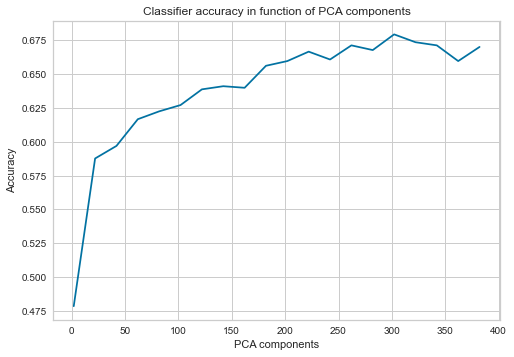

PCA components kept =  302


In [12]:
from sklearn.naive_bayes import MultinomialNB

#number of pca components that maximizes accuracy

n = acc_vs_pca(MultinomialNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29]), 
           pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 402, 20))

print('PCA components kept = ', n)

In [13]:
model = MultinomialNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])
conf_pred, acc, pr, rec, f1, spec = report_values(model, pca_train, y_train, pca_test, y_test, n)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.67      0.82      0.74       259
           2       0.76      0.92      0.83       236
           3       0.60      0.61      0.61       252

    accuracy                           0.68       861
   macro avg       0.51      0.59      0.54       861
weighted avg       0.59      0.68      0.63       861

weighted specificity =  0.8688311760797341


Average precision: 58%

The recall of the last class is rather poor, which means the algorithm is very likely to categorise a class 3 input into another class.

Huge problem on class 0 as it is never predicted.

NB :

$$precision = \frac{TP} {TP + FP}$$

$$recall = \frac{TP} {TP + FN}$$

$$F1 = 2 \frac{precision.recall} {precision + recall}$$

While accuracy simply informs of how often the classification is correct; F1 score informs how often a True Positive is indeed classified as True Positive (recall) as well as, if when a class is predicted, it is actually reliable (precision).

Here we notice a global accuracy somewhat superior to the average, however, F1 score for class 0 and class 3 are weak, which means that the classification concerning these classes are unreliable.

[[  0  18  37  59]
 [  0 213   6  40]
 [  0  15 218   3]
 [  0  72  26 154]]


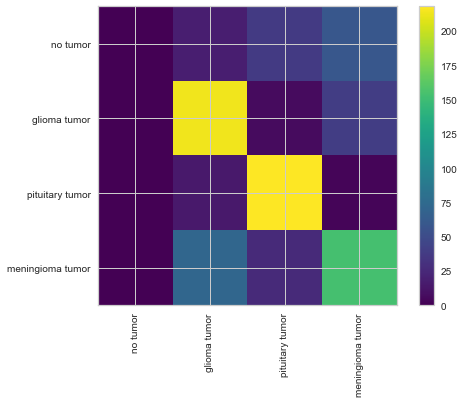

In [14]:
print(conf_pred)

confusion_plot(conf_pred)

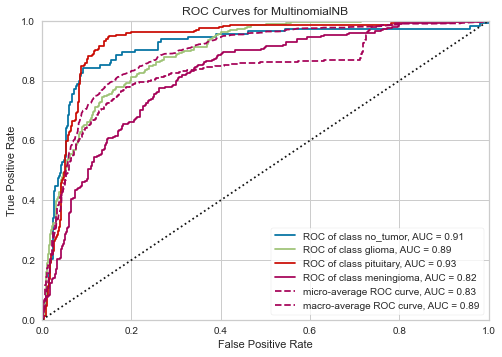

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=MultinomialNB(class_prior=[0.13, 0.29, 0.29, 0.29]))

In [15]:
# ROC analysis

scaler = MinMaxScaler()
Train = scaler.fit_transform(pca_train[:,:n])
Test = scaler.transform(pca_test[:,:n])
plot_ROC_curve(model, Train, y_train, Test, y_test)

We can see that the ROC curves are satisfying with high areas under the curve. The classifier has a great TPR-FPR trade-off for all the classes, particularly for class 0, which means that in binary classification it is doing well. However it seems that this metric is not relevant in our case, because in the multi-class case, we've seen that class 0 has literally no recall and precision when we consider 4 classes. The fact that class 0 has high AUC in binary classification is paradoxical and cannot be taken as a meaningful result.
Therefore, the ROC curves aren't realistic and don't give a proper performance evaluation in our case.

In [16]:
# updating buffer
PCA_comp.append(n)
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.83)

### Gaussian Naive Bayes

_Details from sklearn site https://scikit-learn.org/stable/modules/naive_bayes.html_

A Machine Learning algorithm considering data features to be mutually independant and using a gaussian distribution to compute likelihood. Considering Bayes formula, we have :

$P(C_{k}|x) = \frac{P(x|C_{k}) P(C_{k})}{P(x)}$ with $C_{k}$ the k-th class and $x$ an n-feature vector

Using mutual independancy of features, we obtain :


$$P(C_{k}|x)  \propto P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})$$

Therefore the classifier chooses the optimal class $\hat{y}$ by :

$$\hat{y} = \underset{k}{argmax} \Bigg \{P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})\Bigg\} $$

Considering a Gaussian distribution, we have :


$$P(x_{i}=z |C_{k}) = \frac{1}{\sqrt{2 \pi \sigma_{k}^{2}}} \exp{\bigg(-\frac{(z - \mu_{k})^{2}}{2 \sigma_{k}^{2}}\bigg)}$$

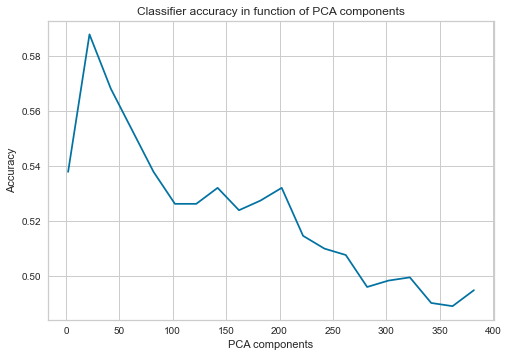

PCA components kept =  22


In [17]:
from sklearn.naive_bayes import GaussianNB

#number of pca components that maximizes accuracy
n = acc_vs_pca(GaussianNB(priors = [0.13, 0.29, 0.29, 0.29]), 
           pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 402, 20))

print('PCA components kept = ', n)

In [18]:
# we choose 20 PCA components as it gives the best accuracy here

model = GaussianNB(priors = [0.13, 0.29, 0.29, 0.29])
conf_pred, acc, pr, rec, f1, spec = report_values(model, pca_train, y_train, pca_test, y_test, n)

              precision    recall  f1-score   support

           0       0.50      0.44      0.47       114
           1       0.52      0.87      0.65       259
           2       0.78      0.75      0.76       236
           3       0.52      0.21      0.30       252

    accuracy                           0.59       861
   macro avg       0.58      0.57      0.55       861
weighted avg       0.59      0.59      0.56       861

weighted specificity =  0.8455171232349108


Average precision: 59%

The recall for class 3 is still poor, but class 0 is actuall predicted this time.

[[ 50  21  16  27]
 [  0 226  11  22]
 [ 14  45 176   1]
 [ 36 140  22  54]]


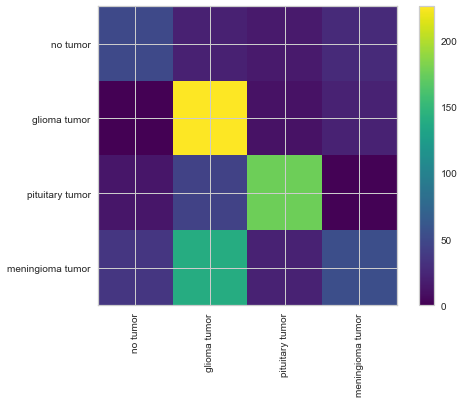

In [19]:
print(conf_pred)

confusion_plot(conf_pred)

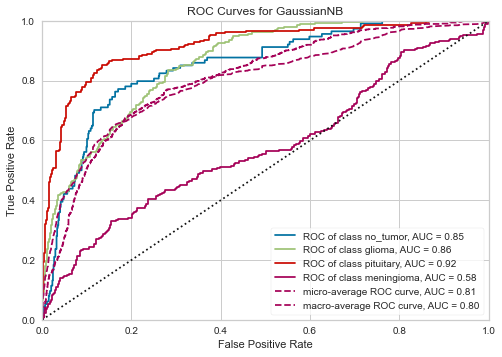

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=GaussianNB(priors=[0.13, 0.29, 0.29, 0.29]))

In [20]:
# ROC curve

scaler = MinMaxScaler()
Train = scaler.fit_transform(pca_train[:,:n])
Test = scaler.transform(pca_test[:,:n])
plot_ROC_curve(model, Train, y_train, Test, y_test)

In [21]:
# updating buffer
PCA_comp.append(n)
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.81)

### Complement Naive Bayes

_Details from sklearn site https://scikit-learn.org/stable/modules/naive_bayes.html_


ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks. The procedure for calculating the weights is as follows:

$$\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j\ne c} d_{ij}}{\alpha + \sum_{j:y_j\ne c}\sum_k d_{kj}}$$

$$w_{ci}=\log\left(\hat{\theta}_{ci}\right)$$

$$w_{ci} = \frac{w_{ci}}{\sum_j \left|w_{cj}\right|}$$

where the summations are over all documents $j$ not in class $c$, $d_{ij}$ is either the count or tf-idf value of term $i$ in document $j$, $\alpha_i$ is a smoothing hyperparameter like that found in MNB, and $\alpha = \sum_i \alpha_i$. The second normalization addresses the tendency for longer documents to dominate parameter estimates in MNB. The classification rule is:

$$\hat{c} = \arg\min_{c}\sum_{i}t_iw_{ci}$$

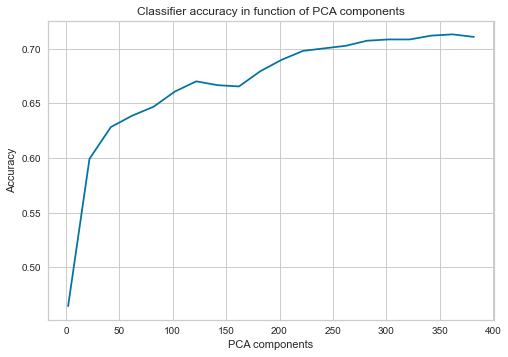

PCA components kept =  362


In [22]:
from sklearn.naive_bayes import ComplementNB

#number of pca components that maximizes accuracy
n = acc_vs_pca(ComplementNB(alpha= 1.0, class_prior = [0.13, 0.29, 0.29, 0.29]), 
           pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 402, 20))

print('PCA components kept = ', n)

In [23]:
# we choose 362 PCA components as it gives the best accuracy here

model = ComplementNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])
conf_pred, acc, pr, rec, f1, spec = report_values(model, pca_train, y_train, pca_test, y_test, n)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       114
           1       0.62      0.90      0.73       259
           2       0.84      0.93      0.88       236
           3       0.75      0.34      0.47       252

    accuracy                           0.71       861
   macro avg       0.72      0.71      0.69       861
weighted avg       0.73      0.71      0.69       861

weighted specificity =  0.8929900183858356


The best result so far, but recall for class 3 is stil not very good, which means it is misclassified.
These relatively good results can come from the fact that Complement Naive Bayes deals better with inbalanced data (which is our case with an under-represented class 0). Indeed, when computing the probability that a sample does __belong to the other classes__, the classifier somehow succeeds in neglecting the impact of the minority class (the under-representation is less visible).

[[ 78  19   9   8]
 [  3 232   5  19]
 [  2  14 219   1]
 [ 31 108  28  85]]


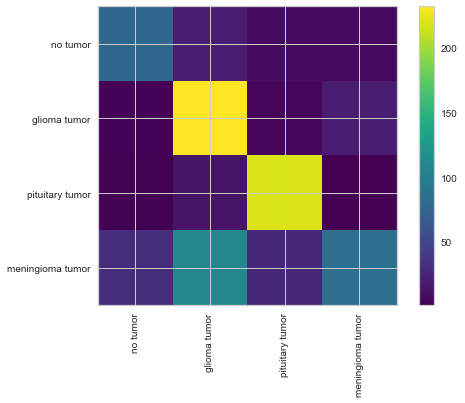

In [24]:
print(conf_pred)

confusion_plot(conf_pred)

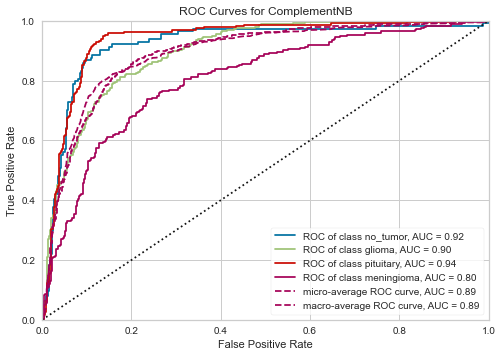

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for ComplementNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=ComplementNB(class_prior=[0.13, 0.29, 0.29, 0.29]))

In [25]:
scaler = MinMaxScaler()
Train = scaler.fit_transform(pca_train[:,:n])
Test = scaler.transform(pca_test[:,:n])
plot_ROC_curve(model, Train, y_train, Test, y_test)

In [26]:
# updating buffer
PCA_comp.append(n)
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.89)

The cross validation shows similar global accuracy than precedently.

### Bernoulli Naive Bayes

_Details from sklearn site https://scikit-learn.org/stable/modules/naive_bayes.html_

BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarize its input (depending on the binarize parameter).

The decision rule for Bernoulli naive Bayes is based on:

$$P\left(x_i \mid y\right) = P\left(x_i = 1 \mid y\right)x_i+\left(1-P\left(x_i=1\mid y\right)\right) \left(1-x_i\right)$$

which differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature $i$ that is an indicator for class $y$, where the multinomial variant would simply ignore a non-occurring feature.

In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

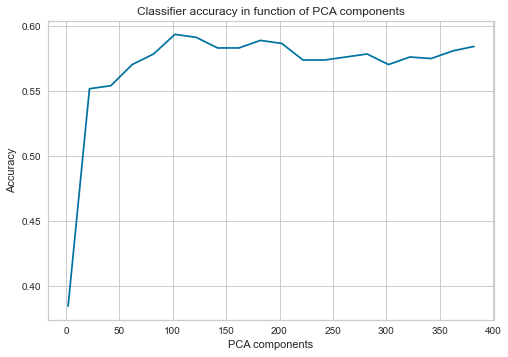

PCA components kept =  102


In [27]:
from sklearn.naive_bayes import BernoulliNB

#number of pca components that maximizes accuracy
n = acc_vs_pca(BernoulliNB(alpha= 1.0, class_prior = [0.13, 0.29, 0.29, 0.29], binarize = 0.5), 
           pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = np.arange(2, 402, 20))

print('PCA components kept = ', n)

In [28]:
# we choose 102 PCA components as it gives the best accuracy here

model = BernoulliNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29], binarize = 0.5)
conf_pred, acc, pr, rec, f1, spec = report_values(model, pca_train, y_train, pca_test, y_test, n)

              precision    recall  f1-score   support

           0       0.67      0.51      0.58       114
           1       0.53      0.82      0.64       259
           2       0.70      0.62      0.66       236
           3       0.58      0.37      0.45       252

    accuracy                           0.59       861
   macro avg       0.62      0.58      0.58       861
weighted avg       0.61      0.59      0.58       861

weighted specificity =  0.8415109095874083


Accuracy ok, near 60%, but strong misclassification on class 3 again (often misclassified as class 1 as seen in the confusion plot).

[[ 58  20  14  22]
 [  0 213  20  26]
 [  2  69 147  18]
 [ 26 103  30  93]]


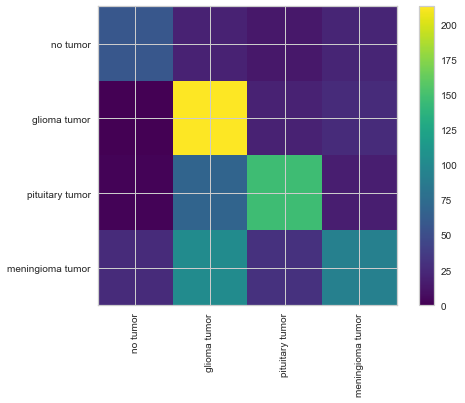

In [29]:
print(conf_pred)

confusion_plot(conf_pred)

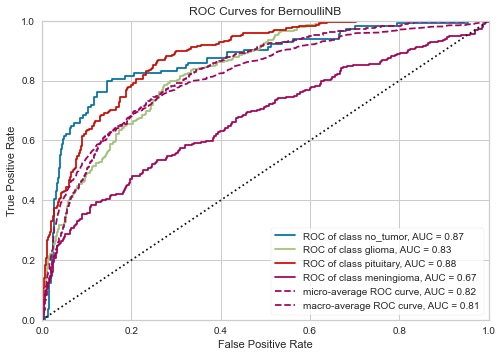

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BernoulliNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=BernoulliNB(binarize=0.5,
                             class_prior=[0.13, 0.29, 0.29, 0.29]))

In [30]:
scaler = MinMaxScaler()
Train = scaler.fit_transform(pca_train[:,:n])
Test = scaler.transform(pca_test[:,:n])

plot_ROC_curve(model, Train, y_train, Test, y_test)

In [31]:
# updating buffer
PCA_comp.append(n)
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.82)

## Complex Bayes Classifier

We don't assume anymore that the features are only dependant on the target (but also on the others).
The library _pomegranate_ allows to compute this kinf of more complex models.
We still assume that each feature follow a Gaussian law (key word in _pomegranate_ library : MultivariateGaussianDistribution), which is a common assumption when not knowing anything about the dataset distribution.

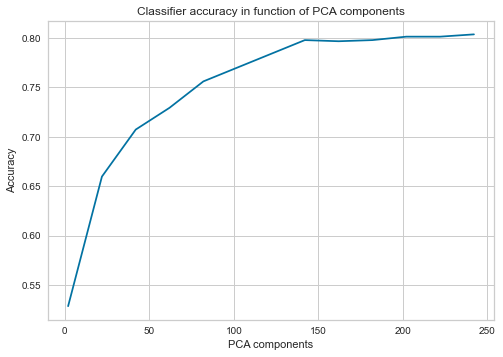

PCA components kept =  242


In [32]:
n_comp = np.arange(2, 252, 20)

n = complex_acc_vs_pca(
           pca_train, y_train, pca_test, y_test, scaler = MinMaxScaler(), n_comp = n_comp)

print('PCA components kept = ', n)

In [33]:


conf_pred, acc, pr, rec, f1, spec = complex_report_values(pca_train, y_train, pca_test, y_test, n)

              precision    recall  f1-score   support

           0       1.00      0.25      0.39       114
           1       0.85      0.87      0.86       259
           2       0.94      0.97      0.95       236
           3       0.65      0.84      0.73       252

    accuracy                           0.80       861
   macro avg       0.86      0.73      0.73       861
weighted avg       0.84      0.80      0.79       861

weighted specificity =  0.9194785293466223


[[ 28   0   6  80]
 [  0 225   3  31]
 [  0   3 228   5]
 [  0  36   5 211]]


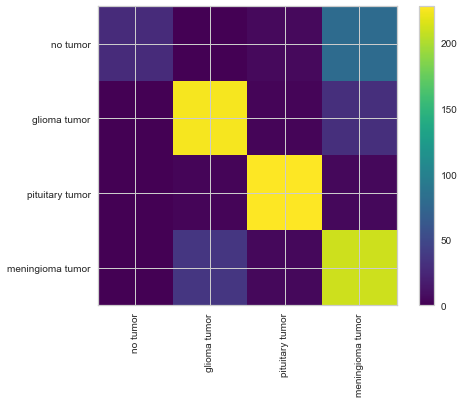

In [34]:
print(conf_pred)
confusion_plot(conf_pred)

Pretty good accuracy, this time class 3 is not often misclassified, but it is the class 0 (no tumor), which displays 100% precision (always right when predicting class 0), but 25% recall : class 0 is often misclassified as class 3 (meningioma tumor). In the last lab we've seen that this confusion could be justified as some MRIs from both classes looked alike.
But in practice, we would rather have a 'no tumor' classified as a 'tumor' than the opposite, so this confusion matrix is kind of acceptable (but not perfect though).

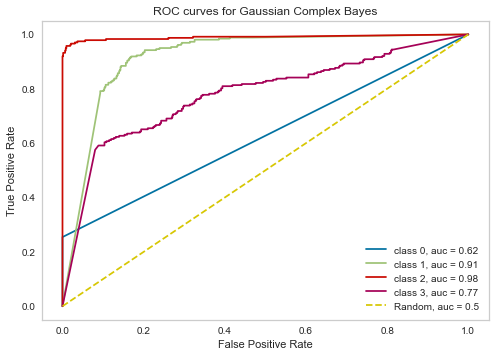

micro avg auc =  0.8519999999999999


In [35]:
#ROC curves

from sklearn.metrics import roc_curve, roc_auc_score

scaler = MinMaxScaler()
Train = scaler.fit_transform(pca_train[:,:n])
Test = scaler.transform(pca_test[:,:n])

plt.figure()

plt.title("ROC curves for Gaussian Complex Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

TPR_mean = np.zeros(6)
auc_mean = 0
p = [0.13, 0.29, 0.29, 0.29]

for i in range(4):
    Y_train = (y_train==i).astype('int')
    Y_test = (y_test==i).astype('int')

    model = BayesClassifier.from_samples(MultivariateGaussianDistribution, Train, Y_train)
    bayes_prob = model.predict_proba(Test)[:,1]

    auc = roc_auc_score(Y_test, bayes_prob) 
    auc =  int(auc*100)/100
    
    b_fpr, b_tpr, _ = roc_curve(Y_test, bayes_prob)
    auc_mean += p[i]*auc
    plt.plot(b_fpr, b_tpr, label = "class {}, auc = {}".format(i, auc))
    
rand_prob = np.zeros(y_test.size)
rand_auc = roc_auc_score((y_test==1).astype('int'), rand_prob)
r_fpr, r_tpr, _ = roc_curve((y_test==1).astype('int'), rand_prob)
plt.plot(r_fpr, r_tpr, linestyle = '--', label = "Random, auc = {}".format(rand_auc))  

plt.legend()
plt.grid()
plt.show()

print('micro avg auc = ', auc_mean)


In [36]:
# updating buffer
PCA_comp.append(n)
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(auc_mean)

## Resume

In [37]:
data = {'Classifiers':  classifiers,
        'PCA components': PCA_comp,
        'Accuracy' : Acc,
        'Weighted Precision': Pr,
        'Weighted Recall' : Rec,
        'Weighted Specificity' : Spec,
        'Weighted F1 Score' : F1,
        'Weighted AUC' : AUC
        }

resume = pd.DataFrame(data)

print(resume)

   Classifiers  PCA components  Accuracy  Weighted Precision  Weighted Recall  \
0  Multinomial             302  0.679443            0.585756         0.679443   
1     Gaussian              22  0.587689            0.589949         0.587689   
2   Complement             362  0.713124            0.727845         0.713124   
3    Bernoulli             102  0.593496            0.609654         0.593496   
4      Complex             242  0.803717            0.835878         0.803717   

   Weighted Specificity  Weighted F1 Score  Weighted AUC  
0              0.868831           0.628048         0.830  
1              0.845517           0.556723         0.810  
2              0.892990           0.689321         0.890  
3              0.841511           0.582521         0.820  
4              0.919479           0.785846         0.852  


## Conclusion of study

Complement and Gaussian Complex Bayes are the best Bayesian classifiers so far.
Complement Bayes displays pretty good results (71% of accuracy, almost 70% of f1-score) compared to the others, supposedly because it deals well with imbalanced dataset, which is our case here with class 0 representing only 13% while the others represent 29% of the dataset. Indeed, the computing of the complement probabilities (i.e. probability that a sample does belong to other classes) succeeds somehow in neglecting the effect of having a minority class (whereas the multinomial one never predicts the minority class).

The Complex Bayes classifier, assumes that there exist condistional dependencies between classes (and not only with the target),  which is a less severe - and most likely false - assumption than the Naive Bayes' one. Therefore, it succeeds in producing more robust results : 80% of accuracy, nearly 80% of F1-score. 

All the classifiers display somewhat good ROC metrics, with an AUC micro-average always superior to 80%. However, as we've seen with the Multinomial Bayes Classifier, this metric doesn't seem relevant to our problem as it tells us how good the classifiers' TPR-FPR tradeoffs are in binary cases, but doesn't tell much in the multiclass problem.

Finally, we've seen that the Bayes classifiers generally confuse 3 classes :
Meningioma (class 3) with Glioma (class 1), and no tumor (class 0) with Meningioma.
We can argue that clinically speaking, the fact that the Complex Bayes Classifier misclassifies 'no tumor' as 'meningioma tumor' is less problematic than the opposite.

The Bayes classifiers don't seem to be particularly suited to our problem, unless maybe for the Complex one which has more general conditional assumptions and better results. The main defaults of the algorithms are the naive assumption (inter-class conditional independance), which is severe, and also the assumptions on the data distribution.
In our case, where the features are computed by PCA, the actual distribution isn't very clear, but at the same time, not likely to follow a Bernoulli or a Multinomial distribution, more suited to problems where data is discretized (like word counting).